In [0]:
import os
import sys

In [0]:
# Define the path one level up
parent_directory = os.path.join(os.getcwd(), '../../Workspace/Users/iaaph@energinet.dk/')
# Add this path to the sys.path list
sys.path.append(f"{parent_directory}")

from utils.TimeGan import TimeGAN
from utils.sequencer import RollingWindow
from utils.normalizer import Scaling
from utils.preprocessor import Preprocessor
from utils.Data_splitting import create_split_indices, split_data_with_indices
from utils.composer import Compose
from config import ModelParameters, TrainingParameters

from performance_metrics.discriminative_score import calculate_discriminative_scores
from performance_metrics.Prediction_models import CNN_GRU_regression
# from performance_metrics.mmd import calculate_mmd
from performance_metrics.evaluation_measures import calculate_metrics
from performance_metrics.pearson_corr import calculate_pearson_correlations

from visualization.pca_tsne import pca_tsne_real_vs_synth
from visualization.plot_sequences import plot_real_vs_synthetic_sequences

In [0]:
import pandas as pd
import numpy as np

from mltable import from_delta_lake
from PIL import Image

In [0]:
url = "abfss://ML_Stab_TI_Energinet_EBI@onelake.dfs.fabric.microsoft.com/Ines.Lakehouse/Tables/mw08003_complete_extended"

tl = from_delta_lake(url)

display(tl)

paths:
- folder: abfss://ML_Stab_TI_Energinet_EBI@onelake.dfs.fabric.microsoft.com/Ines.Lakehouse/Tables/mw08003_complete_extended
transformations:
- read_delta_lake:
    include_path_column: false
type: mltable

In [0]:
df = tl.to_pandas_dataframe()
df.rename(columns = {'Zeitpunkt_x': 'Zeitpunkt'}, inplace=True)
df.sort_values('Zeitpunkt', inplace= True)
df['Wert'] = df['Wert'].astype(float)

df.reset_index(drop=True, inplace=True)

# Filter the rows where the year in 'Zeitpunkt' 
df_ = df[df['Zeitpunkt'].dt.year >= 2022]

Resolving access token for scope "https://storage.azure.com/.default" using identity of type "USER".


InteractiveBrowserCredential.get_token failed: Failed to open a browser


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code G85ZEGSBE to authenticate.


DeviceCodeCredential.get_token failed: Authentication failed: AADSTS70020: The provided value for the input parameter 'device_code' is not valid. This device code has expired. Trace ID: e939e85b-7c02-4a7b-a1cf-3d40f450d200 Correlation ID: 6bb791b3-8a4c-4ea5-a905-97cbe7ca0a39 Timestamp: 2024-05-21 07:43:11Z
Content: {"error":"expired_token","error_description":"AADSTS70020: The provided value for the input parameter 'device_code' is not valid. This device code has expired. Trace ID: e939e85b-7c02-4a7b-a1cf-3d40f450d200 Correlation ID: 6bb791b3-8a4c-4ea5-a905-97cbe7ca0a39 Timestamp: 2024-05-21 07:43:11Z","error_codes":[70020],"timestamp":"2024-05-21 07:43:11Z","trace_id":"e939e85b-7c02-4a7b-a1cf-3d40f450d200","correlation_id":"6bb791b3-8a4c-4ea5-a905-97cbe7ca0a39","error_uri":"https://login.microsoftonline.com/error?code=70020"}
ChainedTokenCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	InteractiveBrowserCredential: Failed to open a browser
	

Resolving access token for scope "https://storage.azure.com/.default" using identity of type "USER".
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code DTTQU53KJ to authenticate.


In [0]:
# from databricks.feature_store import FeatureStoreClient
# # Initialize the feature store client
# fs = FeatureStoreClient()

# # We can then load the feature tabel with the following command
# spark_df2 = fs.read_table("stl_wert")
# spark_df2

# # Assuming you have a Spark DataFrame called spark_df
# df_ = spark_df2.toPandas()

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-2786886196953101>, line 6
      3 fs = FeatureStoreClient()
      5 # We can then load the feature tabel with the following command
----> 6 spark_df2 = fs.read_table("mw08003.csv")
      7 spark_df2
      9 # Assuming you have a Spark DataFrame called spark_df

File /local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/databricks/feature_store/client.py:419, in FeatureStoreClient.read_table(self, name, **kwargs)
    406 """
    407 Read the contents of a feature table.
    408 
   (...)
    412   exist.
    413 """
    414 name = uc_utils.get_full_table_name(
    415     name,
    416     self._spark_client.get_current_catalog(),
    417     self._spark_client.get_current_database(),
    418 )
--> 419 return self._compute_client.read_table(
    420     name=name, client_name=request_context.FEAT

In [0]:
# filepath = os.path.join(parent_directory, 'wert_stl.csv')
# df_.to_csv(filepath, index=False)

In [0]:
attributes = ['Wert'] # ['deseasonalized_wert', '24seasonality',  '168seasonality', '2920seasonality']
feature_n = len(attributes)
seq_length = 24*7
time_col = 'Zeitpunkt'

### Initialize ###
# Initialize the Scaling class
scaler = Scaling(value_cols=attributes)

# Initialize sequencer
sequencer = RollingWindow(seq_number=seq_length, time_col=time_col, value_cols=attributes)

# Initialize preprossing
preprocessor = Preprocessor(data=df_, normalizer=scaler, sequencer=sequencer)

processed_data = preprocessor.preprocess()


In [0]:
# Defining model and training parameters
model_params = ModelParameters(
    batch_size=100,
    lr=0.001,
    betas=(0.2, 0.9),
    latent_dim=20,
    gp_lambda=2,
    pac=1,
    hidden_dim=feature_n  
)

train_params = TrainingParameters(
    epochs=5000,
    sequence_length=seq_length,  
    sample_length=24,
    rounds=1,
    measurement_cols=attributes,  
    number_sequences=feature_n
)

In [0]:
time_gan = TimeGAN(model_parameters = model_params)

In [0]:
time_gan.fit(processed_data, train_arguments=train_params, num_cols = attributes)

num col: ['Wert'], sequence length: 168 and n sequence: 1


Embedding network training:   6%|▋         | 317/5000 [01:

*** WARNING: max output size exceeded, skipping output. ***

Joint networks training: 100%|██████████| 5000/5000 [9:54:08<00:00,  7.13s/it]


In [0]:
# Number of samples to generate
synthetic_data = np.asarray(time_gan.sample(len(processed_data)))

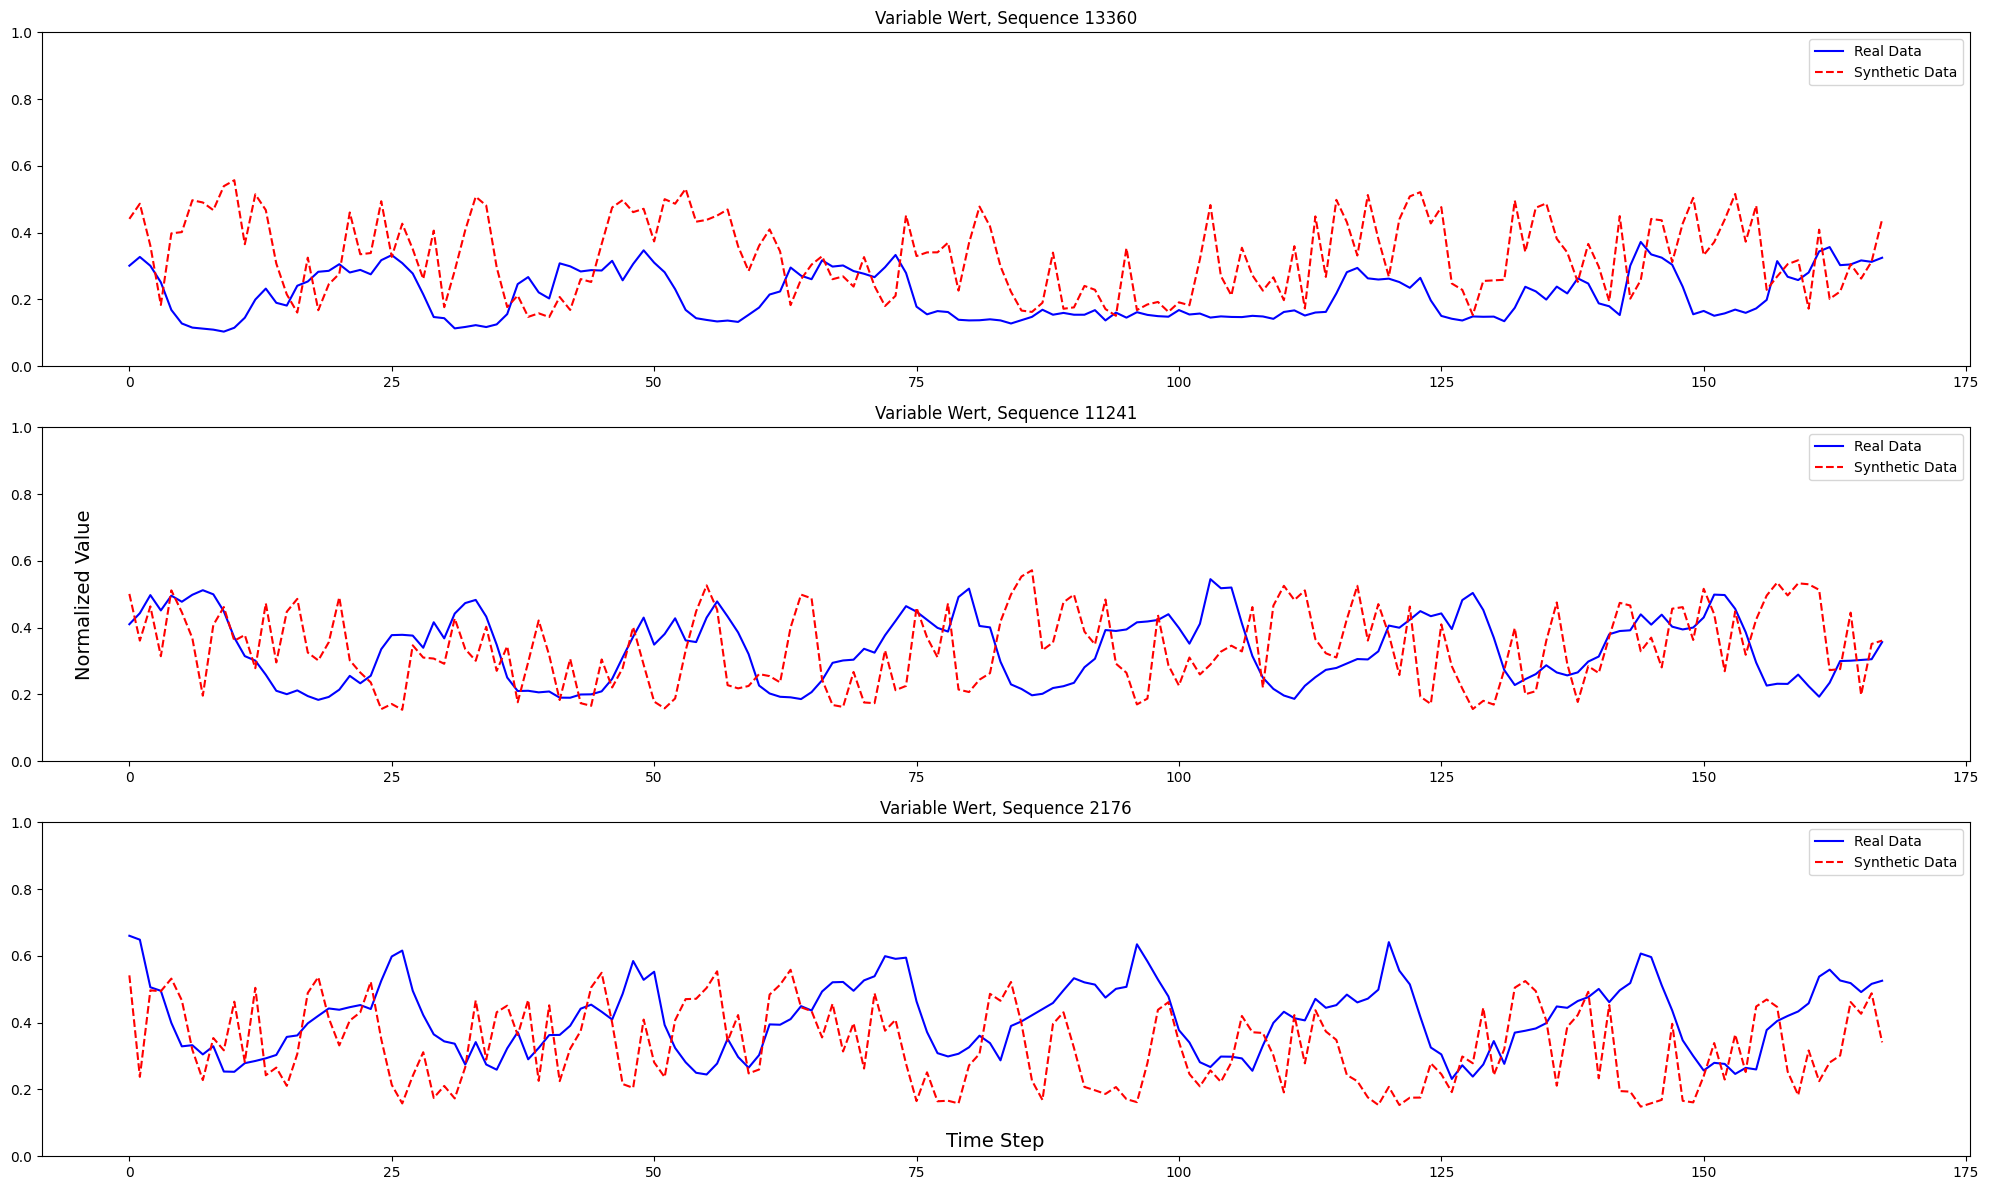

In [0]:
fig = plot_real_vs_synthetic_sequences(processed_data, synthetic_data, attributes)

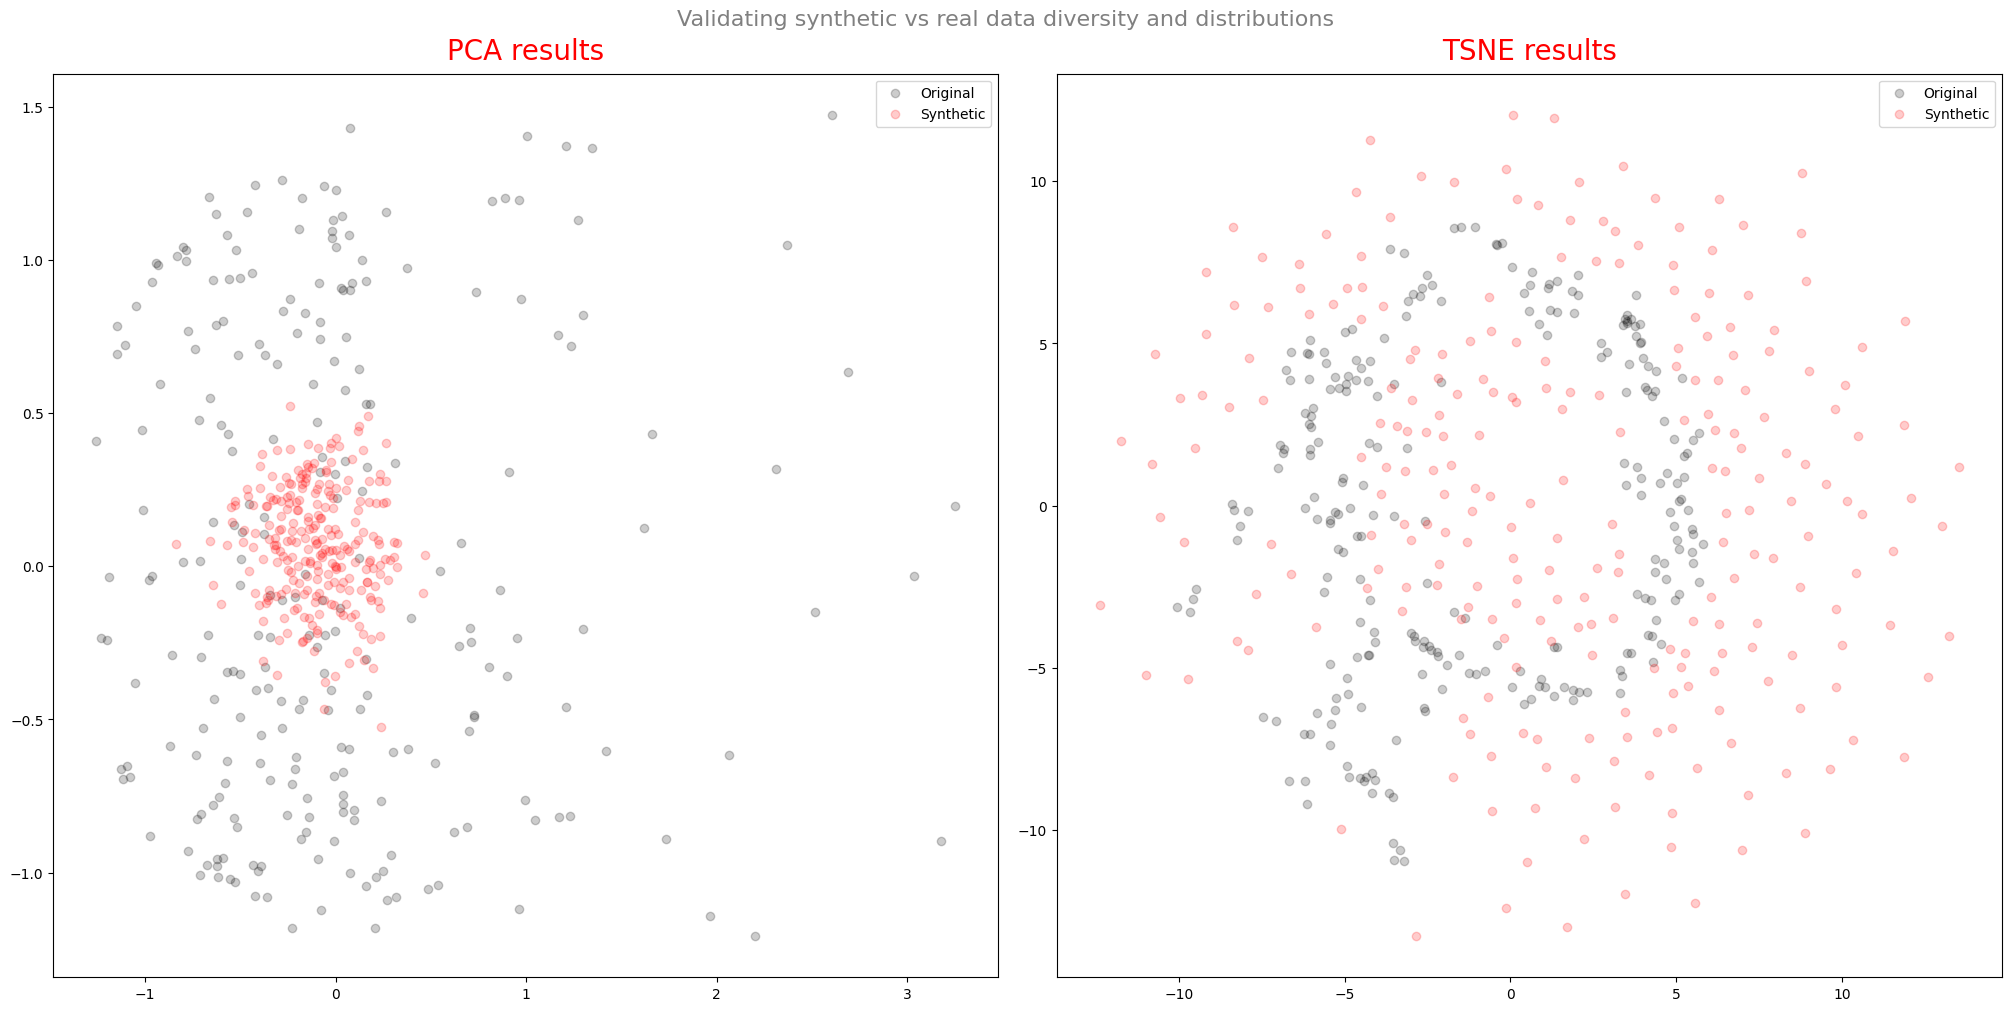

In [0]:
fig2 = pca_tsne_real_vs_synth(processed_data, synthetic_data, seq_length)

# Composition

In [0]:
# from sklearn.preprocessing import MinMaxScaler
# num_samples = len(processed_data)
# scaler_real = MinMaxScaler()
# scaler_synth = MinMaxScaler()

# # Compose the real and synthetic datasets
# final_array = Compose(processed_data, scaler, scaler_real, num_samples, seq_length, feature_n, attributes)
# final_array_synth = Compose(synthetic_data, scaler, scaler_synth, num_samples, seq_length, feature_n, attributes)

# fig_wert = plot_real_vs_synthetic_sequences(final_array, final_array_synth, ['Wert'])

# fig2_wert = pca_tsne_real_vs_synth(final_array, final_array_synth, seq_length)

# processed_data = final_array
# synthetic_data = final_array_synth

# Performance metrics

In [0]:
# Calculate Pearson correlations
pearson_corrs_synthetic = calculate_pearson_correlations(
    processed_data, synthetic_data
)

print(f'The pearson correlation for synthetic data {pearson_corrs_synthetic}')

The pearson correlation for synthetic data [-9.963508421491926e-05]


Discriminate score

In [0]:
# Assuming target_col_indices = [0, 1] because 'wert' is at index 0 and 'temp' is at index 1
target_col_indices = [0]


In [0]:
discriminative_scores = calculate_discriminative_scores(processed_data, synthetic_data, target_col_indices)
print(discriminative_scores)


{0: 0.47668324149979846}


Prediction

In [0]:
# Create split indices based on the total number of sequences
total_sequences = processed_data.shape[0]
train_indices, validation_indices, test_indices = create_split_indices(
    total_samples=total_sequences,
    test_size=0.10,
    validation_size=0.15
)

# Split the data using the indices
X_real_train, X_real_validation, X_real_test, y_real_train, y_real_validation, y_real_test = split_data_with_indices(
    processed_data=processed_data,
    train_indices=train_indices,
    validation_indices=validation_indices,
    test_indices=test_indices,
    target_col_indices=target_col_indices
)

X_synth_train, X_synth_validation, X_synth_test, y_synth_train, y_synth_validation, y_synth_test = split_data_with_indices(
    processed_data=synthetic_data,
    train_indices=train_indices,
    validation_indices=validation_indices,
    test_indices=test_indices,
    target_col_indices=target_col_indices
)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [0]:
# # Initialize the model
timesteps = seq_length - 1
features = 1
units = 1
train_epoch = 1000

real_model = CNN_GRU_regression(timesteps, units, len(target_col_indices))

# Train the model on real

history = real_model.fit(
    X_real_train, y_real_train,
    validation_data=(X_real_validation, y_real_validation),
    epochs=train_epoch,  # Adjust the number of epochs as needed
    batch_size=128,  # Adjust the batch size as needed
    callbacks=[early_stopping]
    )

Epoch 1/1000
109/109 [==============================] - 5s 22ms/step - loss: 0.1391 - val_loss: 0.0949
Epoch 2/1000
109/109 [==============================] - 2s 19ms/step - loss: 0.0975 - val_loss: 0.0940
Epoch 3/1000
109/109 [==============================] - 2s 19ms/step - loss: 0.0960 - val_loss: 0.0931
Epoch 4/1000
109/109 [==============================] - 2s 19ms/step - loss: 0.0950 - val_loss: 0.0914
Epoch 5/1000
109/109 [==============================] - 2s 21ms/step - loss: 0.0925 - val_loss: 0.0904
Epoch 6/1000
 78/109 [====================>.........] - ETA: 0s - loss: 0.0907

*** WARNING: max output size exceeded, skipping output. ***

426
Epoch 84/1000
109/109 [==============================] - 2s 20ms/step - loss: 0.0508 - val_loss: 0.0420
Epoch 85/1000
109/109 [==============================] - 2s 19ms/step - loss: 0.0505 - val_loss: 0.0426
Epoch 86/1000
109/109 [==============================] - 2s 19ms/step - loss: 0.0509 - val_loss: 0.0423

In [0]:
# Initialize the model
synth_model = CNN_GRU_regression(timesteps, units, len(target_col_indices))

# Train the model
synth_history = synth_model.fit(
    X_synth_train, y_synth_train,
    validation_data=(X_real_validation, y_real_validation),
    epochs=train_epoch,  # Adjust the number of epochs as needed
    batch_size=128,  # Adjust the batch size as needed
    callbacks=[early_stopping]
)

Epoch 1/1000
109/109 [==============================] - 3s 15ms/step - loss: 0.1827 - val_loss: 0.0954
Epoch 2/1000
109/109 [==============================] - 1s 13ms/step - loss: 0.1045 - val_loss: 0.0950
Epoch 3/1000
109/109 [==============================] - 1s 13ms/step - loss: 0.1045 - val_loss: 0.0951
Epoch 4/1000
109/109 [==============================] - 1s 12ms/step - loss: 0.1043 - val_loss: 0.0951
Epoch 5/1000
109/109 [==============================] - 1s 12ms/step - loss: 0.1041 - val_loss: 0.0951
Epoch 6/1000
109/109 [==============================] - 1s 13ms/step - loss: 0.1040 - val_loss: 0.0951
Epoch 7/1000
109/109 [==============================] - 1s 13ms/step - loss: 0.1040 - val_loss: 0.0951


In [0]:
synth_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 166, 4)            12        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 83, 4)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 82, 16)            144       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 41, 16)           0         
 1D)                                                             
                                                                 
 reshape_1 (Reshape)         (None, 41, 16)            0         
                                                                 
 dropout_1 (Dropout)         (None, 41, 16)           

In [0]:
# Generate predictions for CNN_GRU_regression
print('for real')
r_pred = real_model.predict(X_real_test)
print('for synth')
s_pred = synth_model.predict(X_real_test)

for real
59/59 [==============================] - 0s 3ms/step
for synth
59/59 [==============================] - 0s 3ms/step


In [0]:
print('compared synthetic only wert')
r2_scores_and_mae = calculate_metrics(y_real_test, r_pred, s_pred)
print(r2_scores_and_mae)

compared synthetic only wert
Feature 0 contains zero or negative values, MSLE cannot be computed for this feature.
     Feature  R2 Score Real  R2 Score Synth  ...  MAE Synth  MSLE Real  MSLE Synth
0  Feature_0       0.776829       -0.007157  ...   0.098517        NaN         NaN

[1 rows x 7 columns]


Save results to directory

In [0]:
#define path to results
result_file_path = os.path.join(parent_directory, f'results/results_classic_168')

In [0]:
# Function to unpack a list into a variable number of outputs
def unpack_to_n_vars(data_list, n):
    # Return the first `n` elements, or fill with None if the list has fewer elements
    return data_list[:n] + [None] * (n - len(data_list))

In [0]:
n = len(target_col_indices)
pearson_corr_1 = unpack_to_n_vars(pearson_corrs_synthetic, n)
# Keep original unpacking when certain variables have consistent lengths
R2_Score_Real_1 = r2_scores_and_mae['R2 Score Real']
R2_Score_Synth_1 = r2_scores_and_mae['R2 Score Synth']
MAE_Real_1 = r2_scores_and_mae['MAE Real']
MAE_Synth_1 = r2_scores_and_mae['MAE Synth']

In [0]:
# Define the path to the CSV file
csv_file_path = os.path.join(result_file_path, f'168_classic.csv')

num_rows = 5 # remove....

# Check if the CSV file exists
if os.path.exists(csv_file_path):
    # CSV file exists, read it into a DataFrame
    print(f"CSV file '{csv_file_path}' already exists, reading data.")
    existing_df = pd.read_csv(csv_file_path)
    # num_rows = len(existing_df)
    num_rows = 5
    # print(f"The DataFrame has {num_rows} rows.")
else:
    # CSV file does not exist, create a new DataFrame
    print(f"CSV file '{csv_file_path}' does not exist, creating new DataFrame.")
    num_rows = 0 # remove......
    existing_df = pd.DataFrame()

# Define the data for the new row
new_row_data = {'index': num_rows,
                'Pearson Correlation 1': pearson_corr_1,
                'Discriminate Score 1': discriminative_scores[0],
                'R2 Score Real 1': R2_Score_Real_1,
                'R2 Score Synthetic 1': R2_Score_Synth_1,
                'MAE Real 1': MAE_Real_1,
                'MAE Synthetic 1': MAE_Synth_1,
                }

# Append the new row to the existing DataFrame
updated_df = pd.concat([existing_df, pd.DataFrame(new_row_data, index=[0])], ignore_index=True)

# Write the updated DataFrame back to the CSV file
updated_df.to_csv(csv_file_path, index=False)

print("New row added to the CSV file.")


CSV file '/databricks/driver/../../Workspace/Users/iaaph@energinet.dk/results/results_classic_168/168_classic.csv' already exists, reading data.
New row added to the CSV file.


In [0]:
# Create the full file path
file_path = os.path.join(result_file_path, f"real_vs_synth_{num_rows}.png")
# Save the image with the new name at the specified directory
fig.savefig(file_path)

file2_path = os.path.join(result_file_path, f"pca_tsne_{num_rows}.png")
# Save the image with the new name at the specified directory
fig2.savefig(file2_path)

In [0]:
# # Create the full file path
# file_path_wert = os.path.join(result_file_path, f"real_vs_synth_{num_rows}_wert.png")
# # Save the image with the new name at the specified directory
# fig_wert.savefig(file_path_wert)

# file2_path_wert = os.path.join(result_file_path, f"pca_tsne_{num_rows}_wert.png")
# # Save the image with the new name at the specified directory
# fig2_wert.savefig(file2_path_wert)

In [0]:
file_path = os.path.join(result_file_path, f'synthetic_data_flattened_5.csv')

# Flatten the array
flat_array = synthetic_data.flatten()

np.savetxt(file_path, flat_array, delimiter=',')